# This notebook examines trends in the processed cfda.txt file (cfda.pkl)
...and sometimes pulls in data from general.txt (general.pkl) for supplementary info

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import os
import re
import cpi

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_cfda_raw = pd.read_pickle(processed_path + 'cfda.pkl')
df_general = pd.read_pickle(processed_path + 'general.pkl')

# Agency prefix dictionary:
with open(processed_path + 'agency_dict.pkl', 'rb') as f_r:
    agency_dict = pickle.load(f_r)
# Entity code dictionary:
with open(processed_path + 'entity_dict.pkl', 'rb') as f_r:
    entity_dict = pickle.load(f_r)

Filter df_cfda for ease of manipulation. In theory, all federal awards are larger than $0, but there are an awful lot of negative numbers...

In [2]:
df_cfda = df_cfda_raw.copy(deep=True)
df_cfda = df_cfda[df_cfda['AMOUNT'] > 0]
print('Number of CFDA entries: ', len(df_cfda_raw))
print('Number of CFDA entries amount expended > 0: ', len(df_cfda))

Number of CFDA entries:  11065193
Number of CFDA entries amount expended > 0:  10859059


In [3]:
df_cfda.columns

Index(['AUDITYEAR', 'DBKEY', 'EIN', 'CFDA', 'FEDERALPROGRAMNAME', 'AMOUNT',
       'DIRECT', 'PASSTHROUGHAWARD', 'PASSTHROUGHAMOUNT', 'MAJORPROGRAM',
       'TYPEREPORT_MP', 'ELECAUDITSID'],
      dtype='object')

In [4]:
print(len(df_cfda_raw))
print(len(df_cfda))

11065193
10859059


Adjust `AMOUNT` for inflation

In [5]:
df_cfda['AMOUNT_ADJUSTED'] = df_cfda.apply(lambda x: cpi.inflate(x.AMOUNT, x.AUDITYEAR), axis=1)

Split the CFDA string in case want to group by CFDA prefix or suffix

In [6]:
df_cfda_split = df_cfda['CFDA'].str.split('.', n = 1, expand = True)
df_cfda['CFDA_PREFIX'] = df_cfda_split[0]
df_cfda['CFDA_EXT'] = df_cfda_split[1]

Group by sortby and compare total sum over the years

In [7]:
sortby = 'CFDA'

In [8]:
series_sortby_amount = df_cfda.groupby(sortby)['AMOUNT_ADJUSTED'].sum().sort_values(ascending=False)
series_sortby_amount.head(20)

CFDA
93.778     5.808961e+12
84.032     3.269582e+12
17.225     1.327922e+12
10.551     1.082327e+12
20.205     9.179269e+11
84.268     7.916406e+11
93.558     5.666383e+11
84.010     5.140677e+11
10.555     4.337890e+11
84.027     4.079539e+11
84.032G    3.695661e+11
84.063     3.632065e+11
14.871     2.757169e+11
14.157     2.327897e+11
93.RD      2.243172e+11
10.557     1.927820e+11
93.600     1.915974e+11
93.658     1.901487e+11
93.767     1.642976e+11
93.575     1.491848e+11
Name: AMOUNT_ADJUSTED, dtype: float64

For ease of computation, plot the 100 grants that have received the most money since 1997

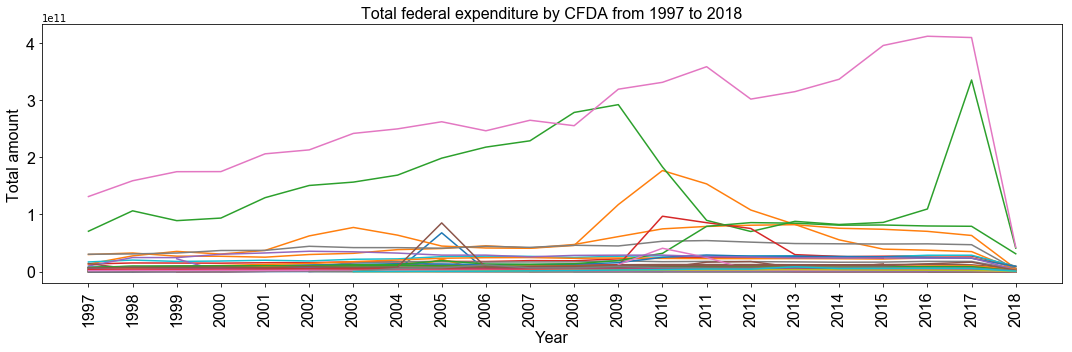

In [9]:
fig, axes = plt.subplots(figsize=(15, 5))
df_year_sortby_amount = df_cfda[df_cfda[sortby].isin(series_sortby_amount.head(100).index)].groupby(
    ['AUDITYEAR', sortby]
)['AMOUNT_ADJUSTED'].sum().unstack()
plot_year_sortby_amount = df_year_sortby_amount.plot(kind='line', fontsize=16, ax=axes, legend=False)
plot_year_sortby_amount.set_xlabel('Year', fontsize=16, fontname='Arial')
plot_year_sortby_amount.set_xticks(df_year_sortby_amount.index)
plot_year_sortby_amount.set_xticklabels(labels=df_year_sortby_amount.index, fontsize=16, fontname='Arial', rotation=90)
plot_year_sortby_amount.set_ylabel('Total amount', fontsize=16, fontname='Arial')
plot_year_sortby_amount.set_title(
    'Total federal expenditure by %s from %s to %s' 
    %(sortby, min(df_cfda['AUDITYEAR']), max(df_cfda['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.yticks(fontsize=16, fontname='Arial')
plt.tight_layout()
plt.show()

In [10]:
year = 2017
series_sortby = df_year_sortby_amount.loc[year].sort_values(ascending=False).head(10)
series_sortby.head()

CFDA
93.778    4.101421e+11
84.032    3.357544e+11
84.268    7.931024e+10
10.551    6.322167e+10
20.205    4.701490e+10
Name: 2017, dtype: float64

In [11]:
df_cfda[(df_cfda['CFDA'] == '93.RD') & (df_cfda['AUDITYEAR'] == 2005)].sort_values('AMOUNT_ADJUSTED', ascending=False)

,AUDITYEAR,DBKEY,EIN,CFDA,FEDERALPROGRAMNAME,AMOUNT,DIRECT,PASSTHROUGHAWARD,PASSTHROUGHAMOUNT,MAJORPROGRAM,TYPEREPORT_MP,ELECAUDITSID,AMOUNT_ADJUSTED,CFDA_PREFIX,CFDA_EXT
10446574,2005,72985,520595110,93.RD,RESEARCH AND DEVELOPMENT OTHER DIVISIONS EXPEN...,56448100000,Y,,,Y,U,21389299,7.257815e+10,93,RD
10446593,2005,72985,520595110,93.RD,RESEARCH AND DEVELOPMENT OTHER DIVISIONS EXPEN...,4144000000,N,,,Y,U,21389316,5.328149e+09,93,RD
987163,2005,131804,943067788,93.RD,PHS NATIONAL INSTITUTES OF HEALTH,1421668000,Y,,,Y,U,21402518,1.827910e+09,93,RD
10260664,2005,65853,430653611,93.RD,NATIONAL INSTITUTES OF HEALTH,382923508,Y,,,Y,U,21375545,4.923439e+08,93,RD
9676920,2005,35765,250965591,93.RD,NATIONAL INSTITUTES OF HEALTH,359695123,Y,,,Y,U,21427899,4.624781e+08,93,RD
10679501,2005,81362,560532129,93.RD,NATIONAL INSTITUTES OF HEALTH,308924922,Y,,,Y,U,21362466,3.972003e+08,93,RD
3221230,2005,15322,135598093,93.RD,NATIONAL INSTITUTES OF HEALTH,292099010,Y,,,Y,U,21385344,3.755663e+08,93,RD
2584010,2005,147719,526002033,93.RD,NATIONAL INSTITUTES OF HEALTH,208483431,Y,,,Y,U,21297524,2.680576e+08,93,RD
2977098,2005,150676,416007513,93.RD,NATIONAL INSTITUTES OF HEALTH,204195491,Y,,,Y,U,21379979,2.625444e+08,93,RD
4220607,2005,16442,136171197,93.RD,U S PUBLIC HEALTH SERVICE DIRECT GRANTS AND CO...,169129998,Y,,,Y,U,21317426,2.174589e+08,93,RD


## Looking at different categories of awards

Filter for entities that received funding from other entities, aka indirect funding. Two ways to filter:
1. Pick entities that have only ever received indirect funding.
2. Pick a year, and pick the 10 entities that received the most indirect funding only in that year.

Then, get the 10 entities that received the most indirect funding (exclude years prior to 2001 since `DIRECT` is wonkily filled out for those years).

In [12]:
# 1. Filtering option 1
# df_year = df_cfda[df_cfda['AUDITYEAR'].isin(range(2001, 2019))]
# 2. Filtering option 2
year = 2001
df_year = df_cfda[df_cfda['AUDITYEAR'] == year]
df_direct = df_year.groupby('EIN')['DIRECT'].value_counts().unstack()
df_only_indirect = df_direct[df_direct['Y'].isna()].sort_values('N', ascending=False)
df_cfda_indirect = df_year[df_year['EIN'].isin(df_only_indirect.index)]
series_indirect_amount = df_cfda_indirect.groupby('EIN')['AMOUNT_ADJUSTED'].sum().sort_values(ascending=False)
top10_indirect = series_indirect_amount.head(10).index
df_top10_indirect = df_cfda[df_cfda['EIN'].isin(top10_indirect)]

Now track those entities through time

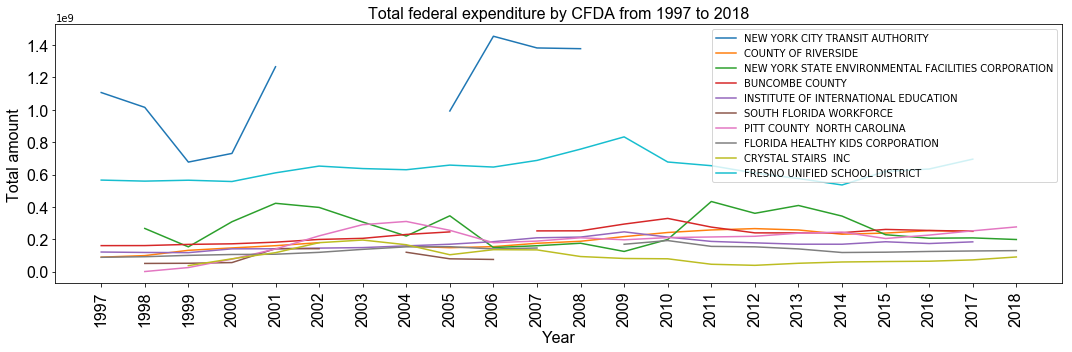

In [13]:
fig, axes = plt.subplots(figsize=(15, 5))
df_top10_indirect_grouped = df_top10_indirect.groupby(['AUDITYEAR', 'EIN'])['AMOUNT_ADJUSTED'].sum().unstack()
ein_names = [df_general[df_general['EIN'] == ein]['AUDITEENAME'].value_counts().idxmax() for ein in top10_indirect]
plot_top10_indirect = df_top10_indirect_grouped.plot(kind='line', fontsize=16, ax=axes)
axes.legend(ein_names)
plot_top10_indirect.set_xlabel('Year', fontsize=16, fontname='Arial')
plot_top10_indirect.set_xticks(df_year_sortby_amount.index)
plot_top10_indirect.set_xticklabels(labels=df_year_sortby_amount.index, fontsize=16, fontname='Arial', rotation=90)
plot_top10_indirect.set_ylabel('Total amount', fontsize=16, fontname='Arial')
plot_top10_indirect.set_title(
    'Total federal expenditure by %s from %s to %s' 
    %(sortby, min(df_cfda['AUDITYEAR']), max(df_cfda['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.yticks(fontsize=16, fontname='Arial')
plt.tight_layout()
plt.show()